Summary Statistics:
            Pclass   Sex         Age       SibSp       Parch        Fare  \
count   891.000000   891  714.000000  891.000000  891.000000  891.000000   
unique         NaN     2         NaN         NaN         NaN         NaN   
top            NaN  male         NaN         NaN         NaN         NaN   
freq           NaN   577         NaN         NaN         NaN         NaN   
mean      2.308642   NaN   29.699118    0.523008    0.381594   32.204208   
std       0.836071   NaN   14.526497    1.102743    0.806057   49.693429   
min       1.000000   NaN    0.420000    0.000000    0.000000    0.000000   
25%       2.000000   NaN   20.125000    0.000000    0.000000    7.910400   
50%       3.000000   NaN   28.000000    0.000000    0.000000   14.454200   
75%       3.000000   NaN   38.000000    1.000000    0.000000   31.000000   
max       3.000000   NaN   80.000000    8.000000    6.000000  512.329200   

       Embarked    Survived  
count       889  891.000000  
unique 

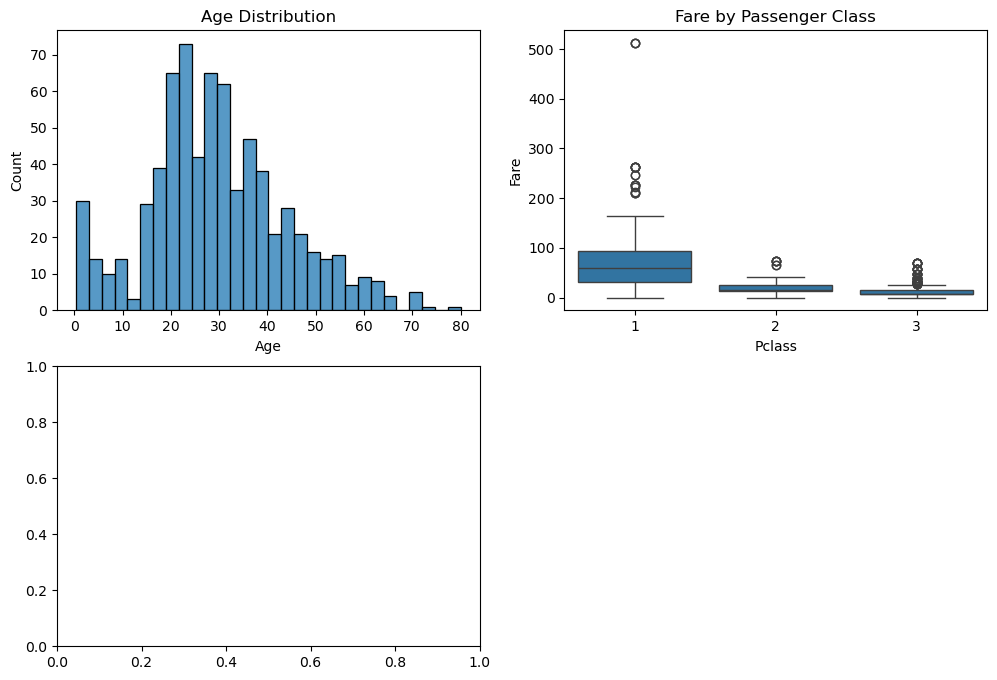

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import streamlit as st
import joblib

# Set random seed for reproducibility
np.random.seed(42)

# Load datasets
def load_data():
    # Load training and test datasets (assumed to be in working directory)
    train_df = pd.read_csv('Titanic_train.csv')
    test_df = pd.read_csv('Titanic_test.csv')
    
    # Select relevant features
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    target = 'Survived'
    
    # Combine for consistent preprocessing
    train_df = train_df[features + [target]].copy()
    test_df = test_df[features + ['PassengerId']].copy()
    
    return train_df, test_df, features, target

# 1. Data Exploration
def explore_data(df):
    print("Summary Statistics:")
    print(df.describe(include='all'))
    
    print("\nData Types:")
    print(df.dtypes)
    
    # Visualizations
    plt.figure(figsize=(12, 8))
    
    # Histogram for Age
    plt.subplot(2, 2, 1)
    sns.histplot(df['Age'].dropna(), bins=30)
    plt.title('Age Distribution')
    
    # Box plot for Fare by Pclass
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Pclass', y='Fare', data=df)
    plt.title('Fare by Passenger Class')
    
    # Pair plot for numerical features
    plt.subplot(2, 2, 3)
    sns.pairplot(df[['Age', 'Fare', 'SibSp', 'Parch', 'Survived']].dropna(), hue='Survived')
    
    # Correlation matrix
    plt.subplot(2, 2, 4)
    df_corr = df.copy()
    le = LabelEncoder()
    df_corr['Sex'] = le.fit_transform(df_corr['Sex'])
    df_corr['Embarked'] = le.fit_transform(df_corr['Embarked'].astype(str))
    sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    
    plt.tight_layout()
    plt.savefig('eda_visualizations.png')
    plt.close()
    
    print("\nCorrelation Observations:")
    print("- Strong negative correlation between Pclass and Fare (higher class, higher fare).")
    print("- Negative correlation between Sex and Survived (males less likely to survive).")
    print("- Moderate correlation between SibSp and Parch (family members travel together).")

# 2. Data Preprocessing
def preprocess_data(train_df, test_df, features, target):
    # Combine datasets for consistent preprocessing
    combined = pd.concat([train_df[features], test_df[features]], axis=0, ignore_index=True)
    
    # Handle missing values (avoid inplace=True)
    combined['Embarked'] = combined['Embarked'].fillna('S')
    combined['Age'] = combined['Age'].fillna(combined['Age'].median())
    combined['Fare'] = combined['Fare'].fillna(combined['Fare'].median())
    
    # Encode categorical variables
    le_sex = LabelEncoder()
    le_embarked = LabelEncoder()
    combined['Sex'] = le_sex.fit_transform(combined['Sex'])
    combined['Embarked'] = le_embarked.fit_transform(combined['Embarked'].astype(str))
    
    # Split back into train and test
    train_processed = combined.iloc[:len(train_df)].copy()
    test_processed = combined.iloc[len(train_df):].copy()
    
    # Split features and target for training
    X_train = train_processed
    y_train = train_df[target]
    
    # Train-test split for evaluation
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_split = scaler.fit_transform(X_train_split)
    X_test_split = scaler.transform(X_test_split)
    X_test_processed = scaler.transform(test_processed)
    
    # Save scaler
    joblib.dump(scaler, 'scaler.pkl')
    
    return (X_train_split, X_test_split, y_train_split, y_test_split,
            X_test_processed, test_df['PassengerId'], le_sex, le_embarked)

# 3. Model Building
def build_and_train_model(X_train, y_train):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # Save model
    joblib.dump(model, 'logistic_model.pkl')
    
    return model

# 4. Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.close()

# 5. Interpretation
def interpret_model(model, features):
    coef = pd.Series(model.coef_[0], index=features)
    print("\nModel Coefficients:")
    print(coef.sort_values(ascending=False))
    
    print("\nInterpretation:")
    print("- Positive coefficients (e.g., Fare, Embarked) increase survival probability.")
    print("- Negative coefficients (e.g., Sex, Pclass) decrease survival probability.")
    print("- Sex has a significant negative impact (males had lower survival odds).")
    print("- Fare has a positive impact (higher-paying passengers had better survival chances).")

# 6. Make Predictions on Test Set
def predict_test(model, X_test_processed, passenger_ids):
    predictions = model.predict(X_test_processed)
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("\nPredictions saved to 'submission.csv'")

# 7. Streamlit App
def create_streamlit_app():
    st.title("Titanic Survival Prediction")
    st.write("Enter passenger details to predict survival probability.")
    
    # Load model and scaler
    model = joblib.load('logistic_model.pkl')
    scaler = joblib.load('scaler.pkl')
    
    # User inputs
    pclass = st.selectbox("Passenger Class", [1, 2, 3])
    sex = st.selectbox("Sex", ["male", "female"])
    age = st.slider("Age", 0, 100, 30)
    sibsp = st.number_input("Siblings/Spouses Aboard", 0, 8, 0)
    parch = st.number_input("Parents/Children Aboard", 0, 6, 0)
    fare = st.number_input("Fare", 0.0, 500.0, 32.0)
    embarked = st.selectbox("Port of Embarkation", ["Cherbourg", "Queenstown", "Southampton"])
    
    # Preprocess inputs
    sex_enc = 1 if sex == "male" else 0
    embarked_map = {"Cherbourg": 0, "Queenstown": 1, "Southampton": 2}
    embarked_enc = embarked_map[embarked]
    
    # Create input array
    input_data = np.array([[pclass, sex_enc, age, sibsp, parch, fare, embarked_enc]])
    input_scaled = scaler.transform(input_data)
    
    # Prediction
    if st.button("Predict"):
        prediction = model.predict(input_scaled)[0]
        probability = model.predict_proba(input_scaled)[0][1]
        
        st.write(f"Survival Prediction: {'Survived' if prediction == 1 else 'Did Not Survive'}")
        st.write(f"Survival Probability: {probability:.2%}")

# Main execution
if __name__ == "__main__":
    # Load and process data
    train_df, test_df, features, target = load_data()
    explore_data(train_df)
    (X_train, X_test, y_train, y_test,
     X_test_processed, passenger_ids, le_sex, le_embarked) = preprocess_data(train_df, test_df, features, target)
    
    # Train and evaluate model
    model = build_and_train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    interpret_model(model, features)
    
    # Predict on test set
    predict_test(model, X_test_processed, passenger_ids)
    
    # For Streamlit, run: streamlit run logistic_regression_titanic.py
    print("\nTo run the Streamlit app, execute: 'streamlit run logistic_regression_titanic.py'")